In [13]:
import pickle
import fairness_metrics
import pandas as pd
from tqdm import tqdm
import utils

In [14]:
ideology_df = pd.read_csv('./data/processed_annotated_comments.csv')
ideology_df['label'] = ideology_df['label'].apply(lambda x: None if x not in ['left', 'right'] else x)
ideology_df.dropna(inplace=True)

main_df = pd.read_csv('./data/jigsaw/main.csv')
dfs = [ideology_df, main_df] 
names = ['ideology', 'jigsaw']

In [15]:
# gold standard moderation
with open('./results/comments_moderated_openai.pkl', 'rb') as handle:
    gold1 = pickle.load(handle)

with open('./results/comments_moderated_perspective_nonmanager.pkl', 'rb') as handle:
    gold2 = pickle.load(handle)

with open('./results/comments_moderation_google.pkl', 'rb') as handle:
    gold3 = pickle.load(handle)

with open('./results/comment_moderation_clarifai.pkl', 'rb') as handle:
    gold4 = pickle.load(handle)

In [16]:
gold1 = utils.process_openai(gold1)
gold2 = utils.process_perspective(gold2)
gold3 = utils.process_google(gold3)
gold4 = utils.process_clarifai(gold4)

gold1 = {k: 0 if v is True else 1 for k,v in gold1.items()}
gold2 = {k: 0 if v is True else 1 for k,v in gold2.items()}
gold3 = {k:0 if v is True else 1 for k,v in gold3.items()}
gold4 = {k:0 if v is True else 1 for k,v in gold4.items()}#{k:0 if max(list(v.values())) >= 0.5 else 1 for k,v in gold4.items()}

20


In [17]:
def compute_percentage_change(main_list, list1):
    indices_unsafe = [i for i, x in tqdm(enumerate(main_list)) if x == 'UNSAFE']
    indices_safe = [i for i, x in tqdm(enumerate(main_list)) if x == 'SAFE']
    indices_map = {'UNSAFE': indices_unsafe, 'SAFE': indices_safe}

    category_map = {
                    'UNSAFE': {'UNSAFE': [], 'SAFE': []},
                    'SAFE': {'UNSAFE': [], 'SAFE': []}
                    }
    for k, v in category_map.items():
        for subk, subv in v.items():
            category_map[k][subk] = [l for idx, l in tqdm(enumerate(list1)) if idx in indices_map[k] and l == subk]
            category_map[k][subk] = len(category_map[k][subk])/len(indices_map[k])

    return category_map

In [18]:
golds = [gold1, gold2, gold3, gold4]

paraphrased = ['./results/comments_backtranslated_german_similarity.pkl', './results/comment_paraphrased_gpt-3.5_final.pkl']
methods = ['openai', 'perspective','google', 'clarifai']
gpt_moderations = [['./results/comments_backtranslated_german_moderated_openai.pkl',
     './results/comments_paraphrased_gpt-3.5_final_moderated_openai.pkl'], 
     ['./results/comments_backtranslated_german_moderation_google_perspective.pkl', 
     './results/comments_moderation_google_perspective_gpt-3.5_final.pkl'],
     ['./results/comments_backtranslated_german_moderation_google_latest_may25.pkl',
     './results/comment_paraphrased_gpt-3.5_final_moderation_google_latest.pkl'],
     ['./results/german_comment_moderation_clarifai.pkl',
     './results/comment_paraphrased_gpt-3.5_final_moderation_clarifai.pkl']]

results = []
global_results = {}

for gold, method, gpt_moderation in zip(golds, methods, gpt_moderations):
    global_results[method] = {}
    submethods = ['backtranslated', 'paraphrased']
    for augmented, moderated, submethod in zip(paraphrased, gpt_moderation, submethods):
        local_gold = gold.copy()
        with open(augmented, 'rb') as handle:
            data = pickle.load(handle)

        with open(moderated, 'rb') as handle:
            mod = pickle.load(handle)

        if 'openai' == method:
            mod = utils.process_openai(mod)
        elif 'perspective' == method:
            mod = utils.process_perspective(mod)
        elif 'google' == method:
            mod = utils.process_google(mod)
        elif 'clarifai' == method:
            mod = utils.process_clarifai(mod)

        if 'backtranslated' == submethod:
            data = {k:v['augmented'] for k,v in data.items() if v['score'] > 0.85 and v['score'] != 1.0}

        
        data = {k:1-int(mod[v]) for k,v in data.items() if v in mod.keys()}

        local_gold = {k:v for k,v in local_gold.items() if k in data.keys()}

        # create lists and compute robustness
        global_results[method][submethod] = {}
        for subset, name in zip(dfs, names):
            df = subset.copy()
            df = df[df['text'].isin(list(local_gold.keys()))]
            a = ['UNSAFE' if local_gold[k] == 0 else 'SAFE' for k in df['text'].tolist()]
            b = ['UNSAFE' if data[k] == 0 else 'SAFE' for k in df['text'].tolist()]
            change_map = compute_percentage_change(a, b)
            global_results[method][submethod][name] = change_map


openai backtranslated
before data 114122


994it [00:00, 2525219.97it/s]
994it [00:00, 727725.29it/s]
994it [00:00, 287506.94it/s]
994it [00:00, 273942.98it/s]
994it [00:00, 91452.54it/s]
994it [00:00, 88939.72it/s]
100530it [00:00, 3551662.58it/s]
100530it [00:00, 2983530.26it/s]
100530it [00:41, 2403.81it/s]
100530it [00:43, 2326.55it/s]
100530it [01:09, 1448.18it/s]
100530it [01:05, 1523.47it/s]


openai paraphrased
before data 114122


1147it [00:00, 1941431.27it/s]
1147it [00:00, 855265.19it/s]
1147it [00:00, 232039.10it/s]
1147it [00:00, 163958.38it/s]
1147it [00:00, 137457.26it/s]
1147it [00:00, 105805.42it/s]
113412it [00:00, 3053937.80it/s]
113412it [00:00, 3291068.13it/s]
113412it [00:45, 2466.66it/s]
113412it [00:45, 2469.00it/s]
113412it [01:15, 1503.36it/s]
113412it [01:15, 1504.61it/s]


perspective backtranslated
before data 114122


994it [00:00, 1485264.76it/s]
994it [00:00, 771205.73it/s]
994it [00:00, 134879.92it/s]
994it [00:00, 175505.71it/s]
994it [00:00, 95862.09it/s]
994it [00:00, 161607.03it/s]
100530it [00:00, 3363271.76it/s]
100530it [00:00, 2810048.39it/s]
100530it [00:13, 7333.56it/s]
100530it [00:13, 7207.90it/s]
100530it [01:09, 1448.53it/s]
100530it [01:09, 1453.06it/s]


perspective paraphrased
before data 114122


1147it [00:00, 1622004.95it/s]
1147it [00:00, 1389219.37it/s]
1147it [00:00, 314826.69it/s]
1147it [00:00, 195373.08it/s]
1147it [00:00, 74706.38it/s]
1147it [00:00, 72616.86it/s]
113412it [00:00, 2735516.33it/s]
113412it [00:00, 2858113.51it/s]
113412it [00:19, 5756.62it/s]
113412it [00:19, 5927.75it/s]
113412it [01:27, 1302.58it/s]
113412it [01:26, 1308.13it/s]


google backtranslated
before data 114122
26


994it [00:00, 2297045.83it/s]
994it [00:00, 2517595.52it/s]
994it [00:00, 91772.62it/s]
994it [00:00, 85712.43it/s]
994it [00:00, 160648.05it/s]
994it [00:00, 223199.22it/s]
100498it [00:00, 2964791.02it/s]
100498it [00:00, 2288141.63it/s]
100498it [01:05, 1536.89it/s]
100498it [01:05, 1541.75it/s]
100498it [00:28, 3552.08it/s]
100498it [00:28, 3556.45it/s]


google paraphrased
before data 114122
26


1147it [00:00, 2532035.10it/s]
1147it [00:00, 1026865.89it/s]
1147it [00:00, 69478.02it/s]
1147it [00:00, 74279.60it/s]
1147it [00:00, 160463.85it/s]
1147it [00:00, 181995.41it/s]
113358it [00:00, 2508959.77it/s]
113358it [00:00, 2873986.24it/s]
113358it [01:26, 1314.70it/s]
113358it [01:26, 1313.64it/s]
113358it [00:39, 2899.40it/s]
113358it [00:38, 2952.21it/s]


clarifai backtranslated
before data 114122


994it [00:00, 864607.67it/s]
994it [00:00, 1016367.18it/s]
994it [00:00, 73520.70it/s]
994it [00:00, 85406.91it/s]
994it [00:00, 261126.03it/s]
994it [00:00, 262970.74it/s]
100530it [00:00, 3205514.53it/s]
100530it [00:00, 2817107.49it/s]
100530it [01:08, 1468.54it/s]
100530it [01:08, 1476.12it/s]
100530it [00:08, 11640.96it/s]
100530it [00:08, 11475.04it/s]


clarifai paraphrased
before data 114122


1147it [00:00, 1279145.62it/s]
1147it [00:00, 1772611.16it/s]
1147it [00:00, 64704.80it/s]
1147it [00:00, 74273.86it/s]
1147it [00:00, 251312.06it/s]
1147it [00:00, 277331.34it/s]
113412it [00:00, 2931636.49it/s]
113412it [00:00, 2784255.04it/s]
113412it [01:28, 1281.86it/s]
113412it [01:28, 1280.25it/s]
113412it [00:11, 9854.38it/s]
113412it [00:11, 9811.88it/s] 

{'openai': {'backtranslated': {'ideology': {'UNSAFE': {'UNSAFE': 0.8897058823529411, 'SAFE': 0.11029411764705882}, 'SAFE': {'UNSAFE': 0.037396121883656507, 'SAFE': 0.9626038781163435}}, 'jigsaw': {'UNSAFE': {'UNSAFE': 0.9181740134403031, 'SAFE': 0.08182598655969685}, 'SAFE': {'UNSAFE': 0.036418930053482346, 'SAFE': 0.9635810699465177}}}, 'paraphrased': {'ideology': {'UNSAFE': {'UNSAFE': 0.2971246006389776, 'SAFE': 0.7028753993610224}, 'SAFE': {'UNSAFE': 0.011990407673860911, 'SAFE': 0.988009592326139}}, 'jigsaw': {'UNSAFE': {'UNSAFE': 0.34940427443003197, 'SAFE': 0.650595725569968}, 'SAFE': {'UNSAFE': 0.02027554626186159, 'SAFE': 0.9797244537381384}}}}, 'perspective': {'backtranslated': {'ideology': {'UNSAFE': {'UNSAFE': 0.9385474860335196, 'SAFE': 0.061452513966480445}, 'SAFE': {'UNSAFE': 0.008588957055214725, 'SAFE': 0.9914110429447853}}, 'jigsaw': {'UNSAFE': {'UNSAFE': 0.9350671001083605, 'SAFE': 0.06493289989163957}, 'SAFE': {'UNSAFE': 0.008392350874815041, 'SAFE': 0.99160764912518

In [19]:
import pickle
with open('heatmap_latest.pkl', 'wb') as handle:
    pickle.dump(global_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

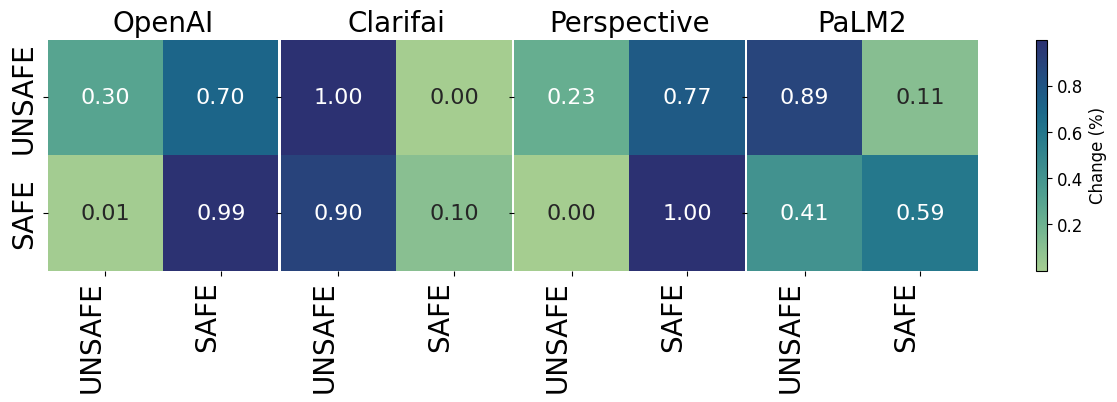

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

labels = ['UNSAFE', 'SAFE']
titles = ['OpenAI', 'Clarifai', 'Perspective', 'PaLM2']

data=[v['paraphrased']['ideology'] for k,v in global_results.items()]
data = [data[0], data[3], data[1], data[2]]

heatmap_data = [np.zeros((2,2)) for _ in range(len(data))]

global_max = -np.inf
global_min = np.inf

for i, row in enumerate(data):
    for j, col in enumerate(row.values()):
        for k, val in enumerate(col.values()):
            heatmap_data[i][j, k] = val
            if val > global_max:
                global_max = val
            if val < global_min:
                global_min = val

fig, axes = plt.subplots(1, len(data), figsize=(15,3), sharey=True)
fig.subplots_adjust(wspace=0.01)
for i, ax in enumerate(axes):
    sns.heatmap(heatmap_data[i], annot=True, fmt=".2f", cmap="crest", xticklabels=labels, yticklabels=labels, ax=ax, annot_kws={"size":16}, vmin=global_min, vmax=global_max, cbar=False)
    ax.set_title(titles[i], fontsize=20)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

cbar = fig.colorbar(axes[0].collections[0], ax=axes, orientation='vertical')
cbar.set_label('Change (%)')
cbar.ax.tick_params(labelsize=12)
cbar.ax.yaxis.label.set_size(12)

plt.show()